# Yield Sources

In [1]:
"""load dependencies and define constants"""
import os
import sys
import requests
import re
import pandas as pd
from decimal import Decimal
from web3 import Web3
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

sys.path.append("..")
from yearn_data.yearn import Yearn
from yearn_data.utils.web3 import get_contract, call

# constants
ZERO_ADDRESS = '0x0000000000000000000000000000000000000000'
FROM_BLOCK = 12965000  # London day
BATCH_SIZE = 500000
API_ENDPOINT = "https://api.etherscan.io/api"

In [2]:
"""get current block and load vaults from the yearn instance"""
load_dotenv()
w3 = Web3(Web3.HTTPProvider(os.environ['WEB3_PROVIDER']))
current_block = w3.eth.get_block("latest")["number"]
print(f"current block number: {current_block}")

yearn = Yearn()
vaults = yearn.vaults
print(f"loaded metadata for {len(vaults)} vaults (v2)")

current block number: 14738489
loaded metadata for 92 vaults (v2)


## Non-Expected Tokens

In [3]:
"""helper functions for searching non-expected tokens"""

MAX_BLOCK = 99999999

def erc20_transfers(address, from_block, to_block):
    endpoint = f"https://api.etherscan.io/api?&apiKey={os.environ['ETHERSCAN_TOKEN']}"
    to_block = MAX_BLOCK if to_block == "latest" else to_block

    params = {
        "address": address,
        "module": "account",
        "action": "tokentx",
        "startblock": str(from_block),
        "endblock": str(to_block),
    }
    response = requests.get(endpoint, params)
    if response.status_code != 200:
        return {}
    txns = response.json()['result']

    result = set({})
    # get the tokens that were sent into the strategy
    for tx in txns:
        if tx["to"].lower() == address.lower():
            token_address = tx['contractAddress']
            result.add(token_address.lower())

    # get the tokens that were handled by the strategy
    for tx in txns:
        if tx["from"].lower() == address.lower():
            token_address = tx['contractAddress']
            result -= set({token_address.lower()})

    return result

def get_name(address):
    endpoint = "https://etherscan.io/address/"
    url = endpoint + address
    headers = {'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.127 Safari/537.36"}
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        return "Network Error!"
    text = response.text
    try:
        start_str = "<title>\r\n\t"
        text = text[text.index(start_str) + 10:]
        text = text[:text.index(" | ")]
        end_str = "\r\n</title>"
        if end_str in text:
            text = text[:text.index(end_str)]
        if text.startswith("Address") or text.startswith("Ethereum Account"):
            return None
        if text.startswith("Contract"):
            return "Contract"
        return text[:100]
    except:
        return None

def get_candidates(address):
    endpoint = "https://etherscan.io/address/"
    url = endpoint + address + '#code'
    headers = {'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.127 Safari/537.36"}
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        return "Network Error!"
    text = response.text
    text = text[text.index("Contract Source Code"):text.index("Contract ABI")]

    candidates = re.findall(r"0x[\w]+", text)
    return set([cand.lower() for cand in candidates if len(cand) == 42])

In [4]:
"""scan for non-expected tokens"""
for strategy in tqdm(yearn.strategies):
    expected_tokens = set({})
    try:
        contract = get_contract(strategy.address)
        # list of expected tokens from the ABI
        for signature in contract.abi:
            if 'outputs' in signature and signature['stateMutability'] == 'view':
                outputs = signature['outputs']
                if any(output['type'] == 'address' for output in outputs) and len(signature['inputs']) == 0 and len(signature['outputs']) == 1:
                    address = call(strategy.address, signature['name'])
                    expected_tokens.add(address.lower())
    except:
        pass
    # list of expected tokens from the source code
    try:
        expected_tokens.update(get_candidates(strategy.address))
    except:
        pass
    if len(expected_tokens) == 0:
        continue

    # list of actual transferred tokens
    tx_tokens = erc20_transfers(strategy.address, FROM_BLOCK, "latest")
    diff = tx_tokens - expected_tokens

    if len(diff) > 0:
        print(strategy.vault.name, strategy.vault.address)
        print(strategy.name, strategy.address)
        print("=" * 80)
        for address in diff:
            name = get_name(address)
            if name is None:
                name = get_name(address)
            print(name, address)
        print("")

  0%|          | 0/273 [00:00<?, ?it/s]

yvRAI 0.4.2 0x873fB544277FD7b977B196a826459a69E27eA4ea
StrategyIdleidleRAIYield 0x5D411D2cde10e138d68517c42bE2808C90c22026
Idle.finance: IDLE Token 0x875773784af8135ea0ef43b5a374aad105c5d39e
Aave: Staked Aave 0x4da27a545c0c5b758a6ba100e3a049001de870f5

yvWETH 0.4.2 0xa258C4606Ca8206D8aA700cE2143D7db854D168c
SSBv3 WETH B-stETH-STABLE 0xB0F8b341951233BF08A5F15a838A1a85B016aEf9
Lido: LDO Token 0x5a98fcbea516cf06857215779fd812ca3bef1b32

yvUSDC 0.4.3 0xa354F35829Ae975e850e23e9615b11Da1B3dC4DE
StrategyGenLevAAVE-Flashmint 0xd4E94061183b2DBF24473F28A3559cf4dE4459Db
BreederDAO 0x8c922299feb8750b2b371e7288a0660308599625
EnginesOfFury 0xe5c26b21f34fbb63f759e82f3fd1a2ea575ed5d8
Contract 0x178689a8ed91557db810884a68942983cabd4f74
StepApp 0x5a73762ea8593f3f61d93638f8a1697df37bf689
PaxWorld 0xe54efd7c803f29d646a9087885a683d2506d6d69

yvSNX 0.3.5 0xF29AE508698bDeF169B89834F76704C3B205aedf
StrategySynthetixSusdMinter 0xc9a62e09834cEdCFF8c136f33d0Ae3406aea66bD
Contract 0x0c7d3abede1e5546d2c2b0807fd52b

## Breakdown of Expected Tokens

In [5]:
"""helper functions for searching the protocol labels"""
MAX_BLOCK = 99999999

def erc20_transfers(address, from_block, to_block):
    endpoint = f"https://api.etherscan.io/api?&apiKey={os.environ['ETHERSCAN_TOKEN']}"
    to_block = MAX_BLOCK if to_block == "latest" else to_block

    params = {
        "address": address,
        "module": "account",
        "action": "tokentx",
        "startblock": str(from_block),
        "endblock": str(to_block),
    }
    response = requests.get(endpoint, params)
    if response.status_code != 200:
        return {}
    txns = response.json()['result']

    result = set({})
    # get the tokens that were handled by the strategy
    for tx in txns:
        if tx["from"].lower() == address.lower():
            token_address = tx['contractAddress']
            result.add(token_address.lower())

    return result

def get_labels(address):
    endpoint = "https://etherscan.io/address/"
    url = endpoint + address
    headers = {'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.127 Safari/537.36"}
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        return "Network Error!"
    text = response.text

    labels = []
    while True:
        try:
            text = text[text.index("/accounts/label/"):]
            text = text[text.index(">") + 1:]
            label = text[:text.index("<")].strip()
            labels.append(label)
        except:
            break
    return labels

labels = []
total_tvl = Decimal(0.0)
for strategy in tqdm(yearn.strategies):
    try:
        tvl = strategy.tvl
    except:
        continue
    total_tvl += tvl

    # list of actual transferred tokens
    tx_tokens = erc20_transfers(strategy.address, FROM_BLOCK, "latest")
    for address in tx_tokens:
        labels.append((get_labels(address), strategy.name, strategy.address, tvl))

  0%|          | 0/273 [00:00<?, ?it/s]

In [6]:
"""create a word dictionary for defi protocols"""
df = pd.DataFrame(labels, columns=['name', 'strategy_name', 'strategy_address', 'strategy_tvl'])

word_dict = {}
for idx in range(len(df)):
    for word in df.name[idx]:
        if word == 'Aave V2':
            if 'Aave' in df.name[idx]:
                continue
            else:
                word = 'Aave'
        if word in word_dict:
            word_dict[word] += df.strategy_tvl[idx]
        else:
            word_dict[word] = df.strategy_tvl[idx]

words = pd.DataFrame(word_dict.items(), columns=['word', 'tvl'])
words.head(10)

,word,tvl
0,USDC,310427493.9429410000000000000
1,Token Contract,1640155345.299614259513272107
2,Compound,143419624.0715180357752058425
3,Wrapped Bitcoin,15974869.35770656658295429087
4,Maker,323733446.1084815632529006214
5,Yearn.Finance,222240038.1243610432556497890
6,Vaults,208344870.5620894263439008568
7,Curve.fi,217310996.3570024416660899815
8,Aave,530508703.0932697575959198202
9,Bitfinex,69325181.71209703487929230589


In [7]:
"""filter out non-informative word tokens"""
exclude = [
    "Token Contract",
    "Proxy Contract",
    "Blocked",
    "Vaults",
    "Yearn.Finance",
    "ygov.finance",
    "USDC",
    "Wrapped",
    "Bitfinex",  # USDT
]
words_filtered = words[~words.word.str.contains("|".join(exclude))]
words_filtered = words_filtered.sort_values('tvl', ascending=False)
words_filtered = words_filtered[words_filtered.tvl > 0]
words_filtered

,word,tvl
8,Aave,530508703.0932697575959198202
4,Maker,323733446.1084815632529006214
7,Curve.fi,217310996.3570024416660899815
2,Compound,143419624.0715180357752058425
21,Balancer,32231849.0332250
22,Liquity,4525579.824114122347754773735
11,Synthetix,2880459.333780944738663219765
13,SushiSwap,1588609.514047961904021952308
15,Uniswap,628169.8914550622206635426956
17,Reflexer Finance,11859.03790242608908614014824


In [8]:
"""fetch data from DeFi Safety"""
endpoint = "https://www.defisafety.com/api/pqrs?status=Active&sortBy=title&sortOrder=ASC&offset="

pqrs = []
offset = 0
while True:
    url = endpoint + str(offset)
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()['data']
        if len(data) == 0:
            break
        pqrs.extend(data)
        offset += 20
    else:
        break

parsed = []
for pqr in pqrs:
    parsed.append((
        pqr['title'],
        pqr['overallScore'],
        pqr['categories'],
        pqr['breakdowns'][0]['percentage'],
        pqr['breakdowns'][1]['percentage'],
        pqr['breakdowns'][2]['percentage'],
        pqr['breakdowns'][3]['percentage'],
        pqr['breakdowns'][4]['percentage'],
    ))

defisafety = pd.DataFrame(parsed, columns=['Name', 'Overall Score', 'Categories', 'Code And Team', 'Documentation', 'Testing', 'Security', 'Access Controls'])
defisafety.head(10)

,Name,Overall Score,Categories,Code And Team,Documentation,Testing,Security,Access Controls
0,0x Protocol,94,[Decentralised Exchange],100,95,82,96,94.0
1,1inch.exchange,85,[Decentralised Exchange],100,82,82,88,69.0
2,88mph V3.0,75,[Yield Farming],88,76,57,96,30.0
3,AAVE V2,96,[Lending / Borrowing],100,93,100,95,89.0
4,Aave V3,94,[Lending / Borrowing],100,97,97,96,83.0
5,Abracadabra.money,43,[Stable Coin],100,14,47,26,30.0
6,ACryptoS,38,"[Yield Farming, AMM]",61,13,0,61,39.0
7,Akropolis,76,[Yield Farming],100,87,57,90,26.0
8,Alchemix,44,"[Assets, Liquidity Provider]",30,40,19,68,54.0
9,Allbridge,28,[Assets],89,43,32,26,0.0


In [9]:
"""apply DeFi Safety scores and categories to the word dictionary"""
data = words_filtered.copy()
data.columns = ['Label', 'TVL']
keys = [
    'Categories',
    'Overall Score',
    'Code And Team',
    'Documentation',
    'Testing',
    'Security',
    'Access Controls',
]
for key in keys:
    data[key] = None

for idx in range(len(data)):
    label = data.Label.iloc[idx].lower()
    _defisafety = defisafety[defisafety.Name.str.lower().str.contains(label)]
    for key in keys:
        data[key].iloc[idx] = _defisafety[key].values

data.Categories = data.Categories.apply(lambda x: list(set([item for sublist in x for item in sublist])))
data.set_index("Label", inplace=True)
data


,TVL,Categories,Overall Score,Code And Team,Documentation,Testing,Security,Access Controls
Label,,,,,,,,
Aave,530508703.0932697575959198202,[Lending / Borrowing],"[96, 94]","[100, 100]","[93, 97]","[100, 97]","[95, 96]","[89.0, 83.0]"
Maker,323733446.1084815632529006214,"[Stable Coin, Lending / Borrowing]",[81],[68],[84],[75],[96],[71.0]
Curve.fi,217310996.3570024416660899815,[AMM],[93],[100],[94],[72],[95],[97.0]
Compound,143419624.0715180357752058425,[Lending / Borrowing],[93],[100],[94],[90],[95],[84.0]
Balancer,32231849.0332250,"[Assets, Liquidity Provider, AMM]","[100, 94]","[100, 100]","[98, 100]","[100, 90]","[100, 99]","[100.0, 82.0]"
Liquity,4525579.824114122347754773735,[Stable Coin],[97],[100],[100],[90],[96],[100.0]
Synthetix,2880459.333780944738663219765,[Assets],[85],[100],[96],[84],[96],[26.0]
SushiSwap,1588609.514047961904021952308,[Decentralised Exchange],[73],[100],[74],[70],[74],[37.0]
Uniswap,628169.8914550622206635426956,"[Liquidity Provider, Decentralised Exchange, AMM]","[94, 96]","[100, 100]","[94, 94]","[93, 80]","[98, 99]","[79.0, 100.0]"


<BarContainer object of 10 artists>

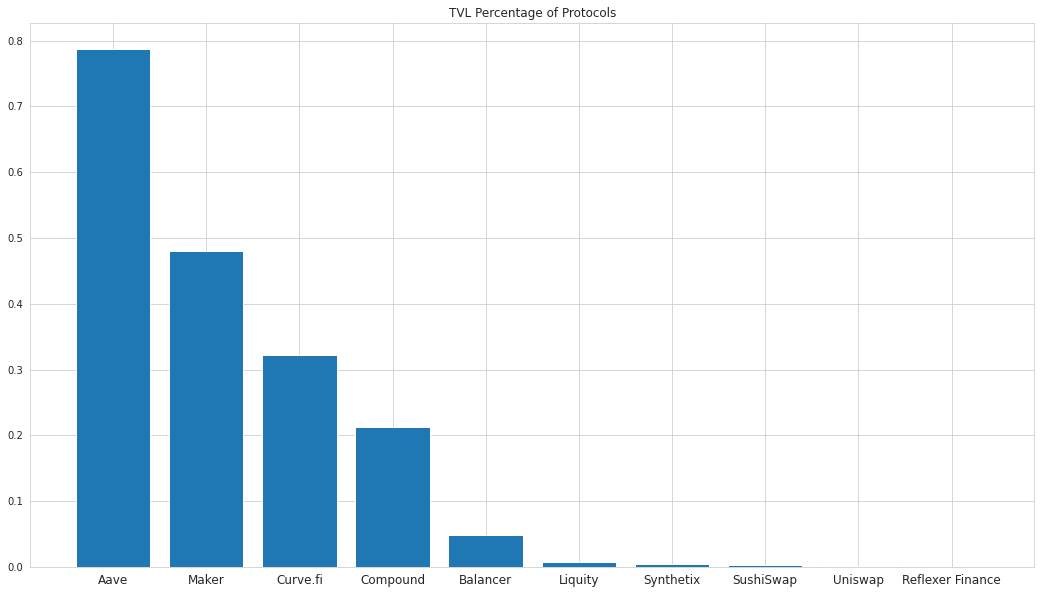

In [10]:
"""TVL distribution of the protocols"""
sns.set_style('whitegrid')
plt.figure(figsize=(18, 10))
plt.title("TVL Percentage of Protocols")
plt.xticks(fontsize=12)
plt.bar(data.index, data.TVL / total_tvl)

In [11]:
"""group the TVL in terms of categories"""
categories = set({})
for _categories in data.Categories:
    categories.update(_categories)

df = pd.DataFrame(index=categories)
df['TVL'] = 0

for category in categories:
    for protocol in data.index:
        if category in data.loc[protocol].Categories:
            df.loc[category, "TVL"] += data.loc[protocol].TVL
df.sort_values("TVL", inplace=True, ascending=False)
df

,TVL
Lending / Borrowing,997661773.2732693566240262841
Stable Coin,328270884.9704981116897415352
AMM,250171015.2816825038867535242
Assets,35112308.36700594473866321976
Liquidity Provider,32860018.92468006222066354270
Decentralised Exchange,2216779.405503024124685495004


<BarContainer object of 6 artists>

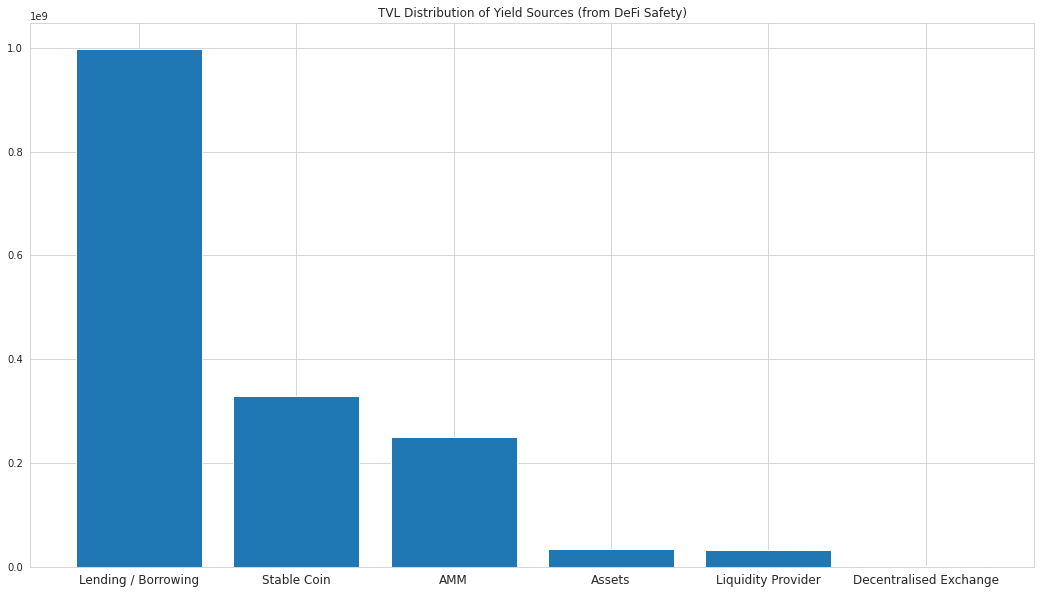

In [12]:
"""TVL distribution of categories"""
sns.set_style('whitegrid')
plt.figure(figsize=(18, 10))
plt.title("TVL Distribution of Yield Sources (from DeFi Safety)")
plt.xticks(fontsize=12)
plt.bar(df.index, df.TVL)